In [1]:
import numpy as np
import scipy as sp 
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt


In [2]:
# def single_run(d_easy, d_hard, theta, var, ns, verbose=False):
verbose = True
ratio = 1
d_easy = 10
d_hard = d_easy * ratio
total_overlap_choices = 10

var = 5.0

test_on_all = True
theta = np.random.rand(d_easy + d_hard) # single parameter vector
ns = [500, 500, 500]

# data distribution
cov_all, cov_easy_no, cov_hard_no = var*np.eye(d_easy + d_hard), var*np.eye(d_easy + d_hard), var*np.eye(d_easy + d_hard)
covs = [cov_easy_no, cov_hard_no, cov_all] # all the same for now

n_tot_train  = np.sum(ns)
n_tot_pseudo = np.sum(ns) # pseudolabel set
n_tot_test   = np.sum(ns) # test set for final eval
X_train   = np.zeros([n_tot_train, d_easy + d_hard]) # data matrix
X_pseudo  = np.zeros([n_tot_pseudo, d_easy + d_hard]) # data matrix
X_test    = np.zeros([n_tot_test, d_easy + d_hard]) # data matrix

y_train, y_pseudo, y_test = np.zeros(n_tot_train), np.zeros(n_tot_pseudo), np.zeros(n_tot_test)
idx, j = 0, 0

for n in ns:
    # gaussian samples
    pts_train = np.random.multivariate_normal(np.zeros(d_easy+d_hard), covs[j], size=n)
    pts_pseudo = np.random.multivariate_normal(np.zeros(d_easy+d_hard), covs[j], size=n)
    pts_test = np.random.multivariate_normal(np.zeros(d_easy+d_hard), covs[j], size=n)
    for i in range(n):
        # generate the labels for all the sets. binary labels uniform prior
        y_train[idx+i] = np.random.randint(2)
        y_pseudo[idx+i] = np.random.randint(2)
        y_test[idx+i] = np.random.randint(2)

        if y_train[idx+i]:
            pts_train[i] += theta #np.ones(d_easy + d_hard) 
        else:
            pts_train[i] -= theta #np.ones(d_easy + d_hard) 
        if y_pseudo[idx+i]:
            pts_pseudo[i] += theta #np.ones(d_easy + d_hard) 
        else:
            pts_pseudo[i] -= theta #np.ones(d_easy + d_hard) 
        if y_test[idx+i]:
            pts_test[i] += theta #np.ones(d_easy + d_hard) 
        else:
            pts_test[i] -= theta #np.ones(d_easy + d_hard) 

    X_train[idx:idx+n], X_pseudo[idx:idx+n], X_test[idx:idx+n] = pts_train, pts_pseudo, pts_test
    if j == 0: # easy only
        X_train[idx:idx+n,d_easy:] = np.zeros([n, d_hard])
        X_pseudo[idx:idx+n,d_easy:] = np.zeros([n, d_hard])
        X_test[idx:idx+n,d_easy:] = np.zeros([n, d_hard])
    elif j == 1: # hard only
        X_train[idx:idx+n,:d_easy] = np.zeros([n, d_easy])
        X_pseudo[idx:idx+n,:d_easy] = np.zeros([n, d_easy])
        X_test[idx:idx+n,:d_easy] = np.zeros([n, d_easy])

    idx += n
    j += 1

# Saliency
X_train[:, :d_easy] = X_train[:, :d_easy]*3
X_pseudo[:, :d_easy] = X_pseudo[:, :d_easy]*3
X_test[:, :d_easy] = X_test[:, :d_easy]*3


# simulate a weak model that cannot take advantage of hard features by zeroing features
X_weak_train = np.copy(X_train)
X_weak_train[:, d_easy:] = np.zeros([ns[0]+ns[1]+ns[2], d_hard])  # all points get hard features zero'd out

X_weak_pseudo = np.copy(X_pseudo)
X_weak_pseudo[:, d_easy:] = np.zeros([ns[0]+ns[1]+ns[2], d_hard])  # all points get hard features zero'd out

X_weak_test = np.copy(X_test)
X_weak_test[:, d_easy:] = np.zeros([ns[0]+ns[1]+ns[2], d_hard])  # all points get hard features zero'd out

# train classifiers
weak_model = LogisticRegression(random_state=0).fit(X_weak_train, y_train)
weak_train_acc_overall = weak_model.score(X_weak_train, y_train)

if test_on_all:
    weak_test_acc_overall  = weak_model.score(X_weak_test, y_test)
else:
    # test on hard for debugging 
    weak_test_acc_overall  = weak_model.score(X_weak_test[ns[0]:ns[0]+ns[1]], y_test[ns[0]:ns[0]+ns[1]])


# how good was the accuracy on just easy points?
weak_train_acc_easy = weak_model.score(X_weak_train[:ns[0]], y_train[:ns[0]])
if verbose:
    print(f"weak model train acc on easy alone = {weak_train_acc_easy}")

# how good was the accuracy on just overlaps?
weak_train_acc_overlaps = weak_model.score(X_weak_train[ns[0]+ns[1]:], y_train[ns[0]+ns[1]:])
if verbose:
    print(f"weak model train acc on overlaps = {weak_train_acc_overlaps}") 


weak model train acc on easy alone = 0.796
weak model train acc on overlaps = 0.814


In [3]:

# pseudolabels generated...
y_pseudolabels = weak_model.predict(X_weak_pseudo)
correct_easy = np.sum(y_pseudo[:ns[0]] == y_pseudolabels[:ns[0]])
correct_overlaps = np.sum(y_pseudo[ns[0]+ns[1]:] == y_pseudolabels[ns[0]+ns[1]:])
if verbose:
    print(f"correct easy was {correct_easy} at this level acc = {correct_easy/ns[0]}")
    print(f"correct overlaps was {correct_overlaps} at this level acc = {correct_overlaps/ns[2]}")

# hard only
# strong_model = LogisticRegression(random_state=0).fit(X_pseudo, y_pseudolabels)
strong_model_train_overlaps = LogisticRegression(random_state=0, C=0.01).fit(X_pseudo[ns[1]+ns[2]:], y_pseudolabels[ns[1]+ns[2]:])
w2s_model = LogisticRegression(random_state=0, C=0.01).fit(X_pseudo, y_pseudolabels)

# all for debugging. first one means no label noise!
#strong_model_train_overlaps = LogisticRegression(random_state=0).fit(X_pseudo[ns[1]+ns[2]:], y_pseudo[ns[1]+ns[2]:])
weights = strong_model_train_overlaps.coef_
# print(f"true weights = \n{theta[:d_easy]}\n{theta[d_easy:2*d_easy]}")
# print(f"lrnd weights = \n{weights[0][:d_easy]}\n{weights[0][d_easy:2*d_easy]}")
print(f"learned weights ={weights}")

strong_pseudo_acc_overlaps = strong_model_train_overlaps.score(X_pseudo[ns[1]+ns[2]:], y_pseudolabels[ns[1]+ns[2]:])
if verbose:
    print(f"strong model trained on overlaps, fitting on pseudo overlaps = {strong_pseudo_acc_overlaps}") 

#strong_model_full = LogisticRegression(random_state=0).fit(X_pseudo, y_pseudolabels)
#strong_pseudo_acc = strong_model_full.score(X_pseudo, y_pseudo)
#print(f"strong model trained on all pseudolabels, fitting on all pseudo= {strong_pseudo_acc}") 

strong_pseudo_acc_pseudo_easy = strong_model_train_overlaps.score(X_pseudo[:ns[0]], y_pseudolabels[:ns[0]])
strong_pseudo_acc_easy = strong_model_train_overlaps.score(X_pseudo[:ns[0]], y_pseudo[:ns[0]])
strong_pseudo_acc_hard = strong_model_train_overlaps.score(X_pseudo[ns[1]:ns[1]+ns[2]], y_pseudo[ns[1]:ns[1]+ns[2]])
if verbose:
    print(f"strong model train overlaps test on pseudo easy = {strong_pseudo_acc_pseudo_easy}") 
    print(f"strong model train overlaps test on true easy = {strong_pseudo_acc_easy}") 
    print(f"strong model train overlaps test on true hard = {strong_pseudo_acc_hard}") 

if test_on_all:
    strong_model_test_acc = strong_model_train_overlaps.score(X_test, y_test)
else:
    strong_model_test_acc = strong_model_train_overlaps.score(X_test[ns[0]:ns[0]+ns[1]], y_test[ns[0]:ns[0]+ns[1]])
if verbose:
    print(f"All points strong model acc = {strong_model_test_acc}")
    print()

# [weak_test_acc_overall, strong_test_acc_oracle, strong_model_test_acc]

correct easy was 424 at this level acc = 0.848
correct overlaps was 413 at this level acc = 0.826
learned weights =[[ 0.05026899  0.07302867  0.03178829  0.23765418  0.34894355  0.20132924
   0.27614822  0.02724251  0.30407661  0.25417898  0.02167264  0.02629124
   0.00416537  0.05138686  0.01060776  0.03356871 -0.02196627  0.09747266
   0.02831235  0.06335807]]
strong model trained on overlaps, fitting on pseudo overlaps = 0.992
strong model train overlaps test on pseudo easy = 0.988
strong model train overlaps test on true easy = 0.852
strong model train overlaps test on true hard = 0.682
All points strong model acc = 0.746



NameError: name 'strong_test_acc_oracle' is not defined

In [4]:
weak_model.coef_

array([[ 0.00774501,  0.02550137,  0.00732891,  0.09088105,  0.13847438,
         0.07733093,  0.10490092, -0.00153524,  0.11289191,  0.09605298,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ]])

In [5]:

# oracle
strong_model_oracle = LogisticRegression(random_state=0).fit(X_train, y_train)
if test_on_all:
    strong_test_acc_oracle = strong_model_oracle.score(X_test, y_test)
else:
    strong_test_acc_oracle = strong_model_oracle.score(X_test[ns[0]:ns[0]+ns[1]], y_test[ns[0]:ns[0]+ns[1]])


In [6]:
weak_model_confidence = 2*np.abs(weak_model.predict_proba(X_pseudo)[:,1] - 0.5)
# Get the indices of the half of lower confidence points
lower_confidence_threshold = np.median(weak_model_confidence)
lower_confidence_indices = np.where(weak_model_confidence <= lower_confidence_threshold)[0]
((lower_confidence_indices>=500)&(lower_confidence_indices<1000)).sum()

500

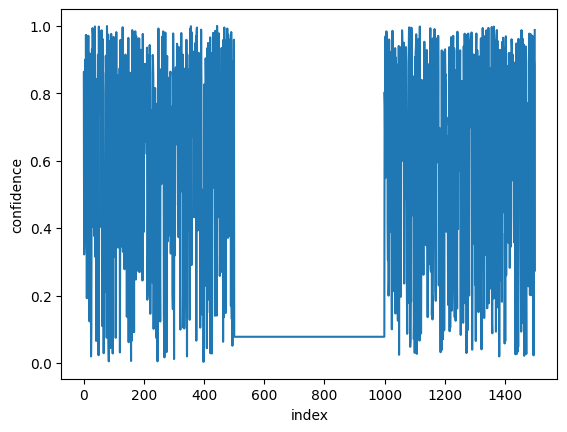

In [7]:
import matplotlib.pyplot as plt
plt.plot(weak_model_confidence)
plt.xlabel('index')
plt.ylabel('confidence')
plt.show()

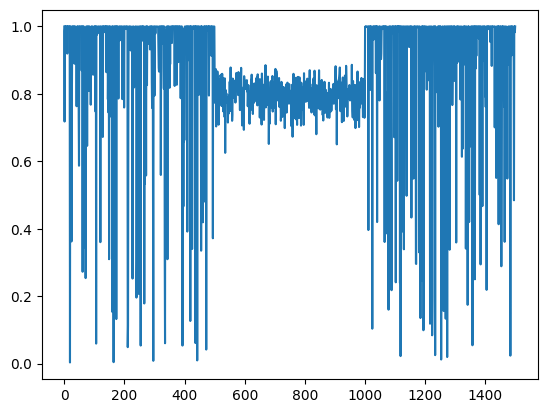

In [8]:
w2s_model_confidence = 2*np.abs(w2s_model.predict_proba(X_pseudo)[:,1] - 0.5)

plt.plot(w2s_model_confidence)
plt.show()

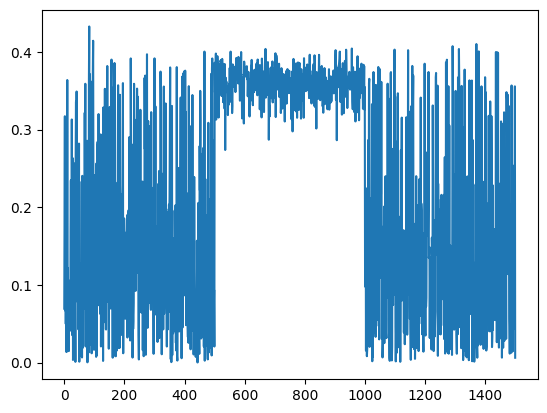

In [9]:
prob_diff = np.abs(w2s_model.predict_proba(X_pseudo)[:,1] - weak_model.predict_proba(X_pseudo)[:,1])

plt.plot(prob_diff)
plt.show()


In [10]:
X_hard_points = X_pseudo[ns[0]:ns[0]+ns[1]]
X_easy_or_overlap = np.concatenate([X_pseudo[:ns[0]], X_pseudo[ns[0]+ns[1]:]])
y_easy_or_overlap = np.concatenate([y_pseudo[:ns[0]], y_pseudo[ns[0]+ns[1]:]])
y_hard_points = y_pseudo[ns[0]:ns[0]+ns[1]]

In [11]:
from tqdm import tqdm
weak_model_scores_on_hard = weak_model.predict_proba(X_pseudo[ns[0]:ns[0]+ns[1]])[:,1]
w2s_model_scores_on_hard = w2s_model.predict_proba(X_pseudo[ns[0]:ns[0]+ns[1]])[:,1]
diff_scores = []
for i in tqdm(range(len(X_easy_or_overlap))):
    x = np.concatenate([X_easy_or_overlap[:i], X_easy_or_overlap[i+1:]])
    y = np.concatenate([y_easy_or_overlap[:i], y_easy_or_overlap[i+1:]])
    model = LogisticRegression(random_state=0).fit(x, y)
    score = np.abs(model.predict_proba(X_hard_points)[:,1] - w2s_model_scores_on_hard).mean()
    diff_scores.append(score)


100%|██████████| 1000/1000 [00:07<00:00, 142.14it/s]


In [13]:
diff_scores

[0.412564276322285,
 0.4121905192179448,
 0.41271748721334733,
 0.41246623604466987,
 0.41280649655007173,
 0.41257267020575816,
 0.41232758761561705,
 0.41251476193312886,
 0.4125814049133712,
 0.41252320994707575,
 0.41298659837708945,
 0.4126177463323198,
 0.4124103844953117,
 0.4124779122464903,
 0.412453397788864,
 0.4125212956413806,
 0.4124069607303164,
 0.4125731103971596,
 0.41241817127026115,
 0.41188654267088165,
 0.41254663083312537,
 0.41291964551582055,
 0.41278327280083343,
 0.41258078915304813,
 0.41199443953467846,
 0.4129979118729655,
 0.41388973814902735,
 0.41254017298236684,
 0.4121482313801764,
 0.4125196210835143,
 0.4125269472169105,
 0.41376415803318617,
 0.4114816823722243,
 0.4126305887166774,
 0.4123158086830471,
 0.4125887728758891,
 0.41422045096663895,
 0.41252214201165693,
 0.4122302359555175,
 0.41277294194071035,
 0.4124095712285284,
 0.41209919508149356,
 0.41237737039687533,
 0.4126009345177851,
 0.4116007704043326,
 0.4125731421936589,
 0.4129028163

In [14]:
# Get the indices of top 500 diff_scores
top_500_indices = np.argsort(diff_scores)[-500:]

# Print the shape of the result to verify
print(f"Shape of top 500 indices: {top_500_indices.shape}")

# # Optionally, you can also print the first few indices to check
# print(f"First few top indices: {top_500_indices[:5]}")


Shape of top 500 indices: (500,)


In [17]:
(top_500_indices>=500).mean()

0.474

In [39]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import numpy as np

class LogisticRegression(nn.Module):
    def __init__(self, input_dim):
        super(LogisticRegression, self).__init__()
        self.linear = nn.Linear(input_dim, 1)
        
    def forward(self, x):
        return torch.sigmoid(self.linear(x))

def train_model(X, y, learning_rate=0.01, epochs=100, batch_size=32):
    X_tensor = torch.FloatTensor(X)
    y_tensor = torch.FloatTensor(y).reshape(-1, 1)
    
    dataset = TensorDataset(X_tensor, y_tensor)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    
    model = LogisticRegression(X.shape[1])
    criterion = nn.BCELoss()
    optimizer = optim.SGD(model.parameters(), lr=learning_rate)
    
    for epoch in range(epochs):
        for inputs, labels in dataloader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
    
    return model

def compute_influence_function(model, X_train, y_train, X_test, learning_rate=0.01):
    X_train_tensor = torch.FloatTensor(X_train)
    y_train_tensor = torch.FloatTensor(y_train).reshape(-1, 1)
    X_test_tensor = torch.FloatTensor(X_test)
    
    criterion = nn.BCELoss()
    
    influences = []
    for i in range(len(X_train)):
        # Compute gradient of loss w.r.t parameters for test point
        model.zero_grad()
        test_output = model(X_test_tensor)
        test_loss = criterion(test_output, torch.zeros_like(test_output))  # Assuming binary classification
        test_loss.backward()
        test_grad = [param.grad.clone() for param in model.parameters()]
        
        # Compute gradient of loss w.r.t parameters for train point
        model.zero_grad()
        train_output = model(X_train_tensor[i].unsqueeze(0))
        train_loss = criterion(train_output, y_train_tensor[i].unsqueeze(0))
        train_loss.backward()
        train_grad = [param.grad.clone() for param in model.parameters()]
        
        # Compute influence
        influence = sum([(tg * pg).sum() for tg, pg in zip(test_grad, train_grad)])
        influences.append(influence.item())
    
    return np.array(influences)

def compute_hessian_vector_products(model, X, y, v):
    X_tensor = torch.FloatTensor(X)
    y_tensor = torch.FloatTensor(y).reshape(-1, 1)
    
    criterion = nn.BCELoss()
    
    model.zero_grad()
    outputs = model(X_tensor)
    loss = criterion(outputs, y_tensor)
    grads = torch.autograd.grad(loss, model.parameters(), create_graph=True)
    
    hvp = torch.autograd.grad(grads, model.parameters(), grad_outputs=v)
    return [h.detach() for h in hvp]

def compute_hessian_based_influence(model, X_train, y_train, X_test, num_iterations=100, learning_rate=0.01):
    X_train_tensor = torch.FloatTensor(X_train)
    y_train_tensor = torch.FloatTensor(y_train).reshape(-1, 1)
    X_test_tensor = torch.FloatTensor(X_test)
    
    criterion = nn.BCELoss()
    
    # Compute test gradient
    model.zero_grad()
    test_output = model(X_test_tensor)
    test_loss = criterion(test_output, torch.zeros_like(test_output))
    test_grad = torch.autograd.grad(test_loss, model.parameters())
    
    # Initialize v
    v = [g.clone() for g in test_grad]
    
    # Perform conjugate gradient iterations
    for _ in range(num_iterations):
        hvp = compute_hessian_vector_products(model, X_train, y_train, v)
        v = [v[i] - learning_rate * hvp[i] for i in range(len(v))]
    
    # Compute influences
    influences = []
    for i in range(len(X_train)):
        model.zero_grad()
        train_output = model(X_train_tensor[i].unsqueeze(0))
        train_loss = criterion(train_output, y_train_tensor[i].unsqueeze(0))
        train_grad = torch.autograd.grad(train_loss, model.parameters())
        
        influence = sum([(tg * pg).sum() for tg, pg in zip(v, train_grad)])
        influences.append(influence.item())
    
    return np.array(influences)



# Example usage
# Assuming X_train, y_train, X_test are your data
model = LogisticRegression(input_dim=X_easy_or_overlap.shape[1])
influences = np.abs(compute_influence_function(model, X_easy_or_overlap, y_easy_or_overlap, X_hard_points))

print("Shape of influences:", influences.shape)
print("Top 5 influential points:", np.argsort(influences)[-500:])


Shape of influences: (1000,)
Top 5 influential points: [121 177  96  50 158 847 411 205 928   0 339 925 120 787 945 414 183  40
 686 883 400 277 397 253 547 667 331 438 129 823 166 920 594 115 999 226
 500 860 242 342  47   6 931 308  89 559 797 220 150 337  11 510 197 140
 113 398 858 990  81 581 285 386 969  90 263 254 367 458 899  19  10 348
 406 132 481  31 580 908 439 716 418 282 379 385 495   4 626 464 196 347
 721  29 645 333 109  72 784 741 604  76  48  70 760 133 139 364 431 937
 730  54 143 211 599  34 119 649  68 237 250 421 357 443 470  84 375 356
 472 449  27 409  88 444  56 467 184 171 380 390 179 979  41 290 315 221
 209 168 187 287 370 175  77 291 319 284  51 313 425 363 122 440 296 245
 232 557 261 137 469 219 213 344 125  66  97 335 399 754 428 562 247 256
 304 767 297 195 103 872 381 592  86  67 233 154 640 199 210 327 465 173
 393  53 346 378 153  71 541 622 919 457  69 325 148 413  38 190 388  20
 110 476 498 160 224 300 234 192 266 279 141  12 311  42   8 283 485 

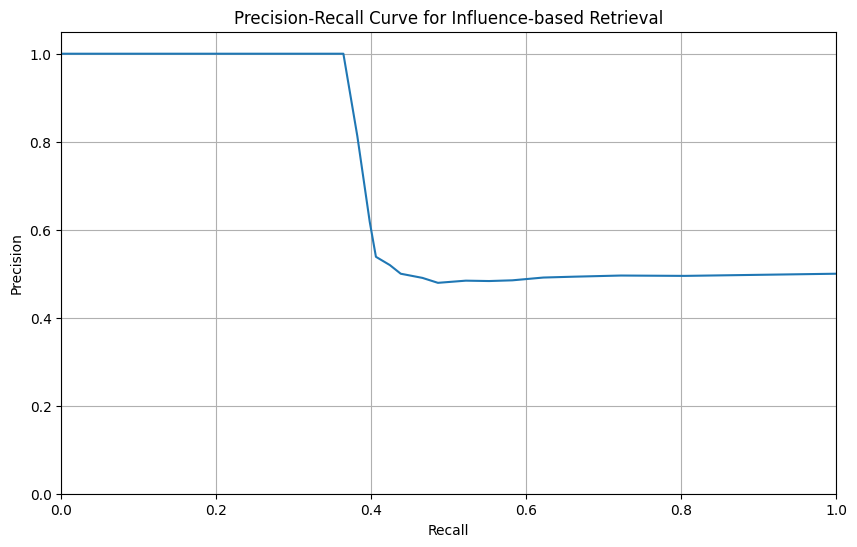

Area Under the Precision-Recall Curve: -0.6880


In [49]:
import matplotlib.pyplot as plt

# Calculate precision at different thresholds
thresholds = np.linspace(0, np.max(influences), 100)
precision = []
recall = []

for threshold in thresholds:
    retrieved = influences >= threshold
    true_positives = np.sum((retrieved) & (np.arange(len(influences)) >= 500))
    false_positives = np.sum((retrieved) & (np.arange(len(influences)) < 500))
    false_negatives = np.sum((~retrieved) & (np.arange(len(influences)) >= 500))
    
    if true_positives + false_positives > 0:
        precision.append(true_positives / (true_positives + false_positives))
    else:
        precision.append(1.0)  # If nothing is retrieved, precision is 1 by convention
    
    if true_positives + false_negatives > 0:
        recall.append(true_positives / (true_positives + false_negatives))
    else:
        recall.append(0.0)

# Plot precision-recall curve
plt.figure(figsize=(10, 6))
plt.plot(recall, precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for Influence-based Retrieval')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.grid(True)
plt.show()

# Calculate and print Area Under the Precision-Recall Curve (AUC-PR)
auc_pr = np.trapz(precision, recall)
print(f"Area Under the Precision-Recall Curve: {auc_pr:.4f}")


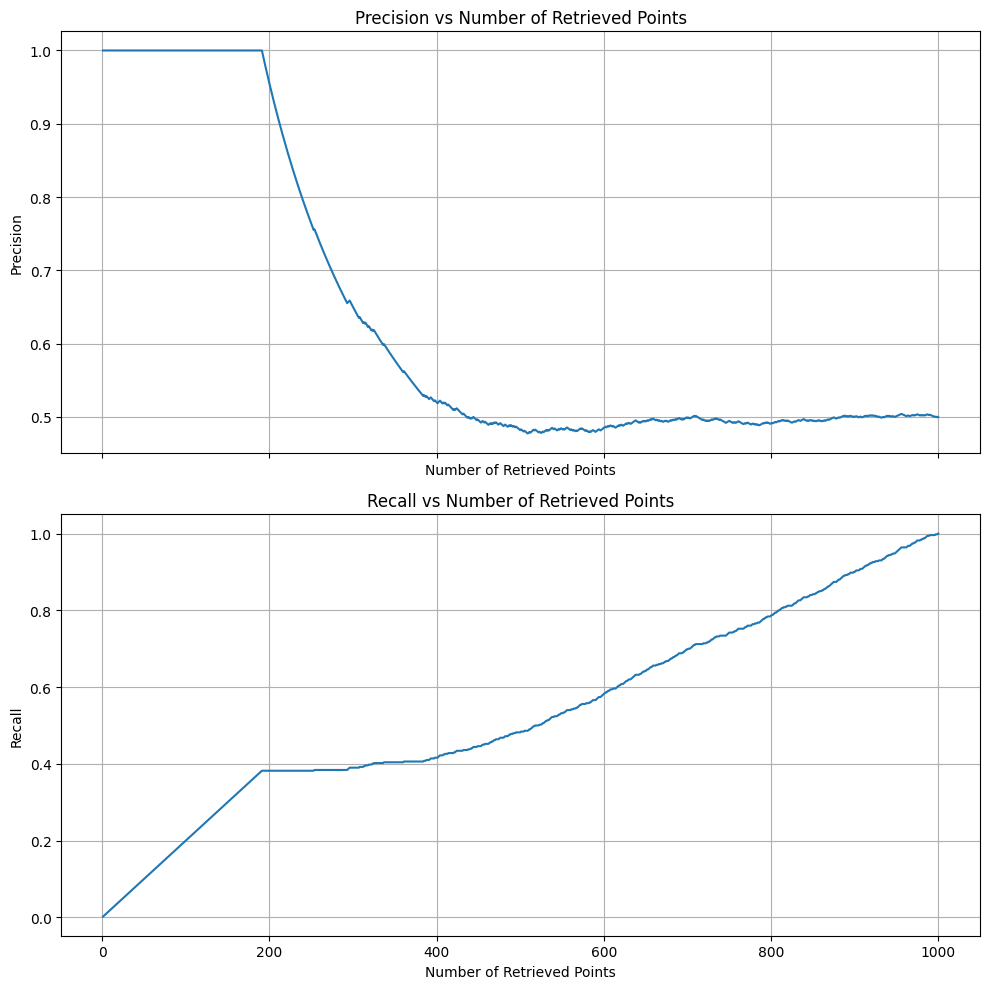

Area Under the Precision-Recall Curve: 0.6890


In [52]:
import matplotlib.pyplot as plt

# Sort influences in descending order
sorted_indices = np.argsort(influences)[::-1]
num_points = len(influences)

precision = []
recall = []
num_retrieved = []

for i in range(1, num_points + 1):
    retrieved = sorted_indices[:i]
    true_positives = np.sum(retrieved >= 500)
    false_positives = np.sum(retrieved < 500)
    false_negatives = np.sum(np.arange(500, num_points) >= i)
    
    precision.append(true_positives / i)
    recall.append(true_positives / 500)  # 500 is the number of overlap points
    num_retrieved.append(i)

# Create subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10), sharex=True)

# Precision subplot
ax1.plot(num_retrieved, precision)
ax1.set_ylabel('Precision')
ax1.set_title('Precision vs Number of Retrieved Points')
ax1.set_xlabel('Number of Retrieved Points')
ax1.grid(True)

# Recall subplot
ax2.plot(num_retrieved, recall)
ax2.set_xlabel('Number of Retrieved Points')
ax2.set_ylabel('Recall')
ax2.set_title('Recall vs Number of Retrieved Points')
ax2.grid(True)

plt.tight_layout()
ax2.set_xlabel('Number of Retrieved Points')
plt.show()

# Calculate and print Area Under the Precision-Recall Curve (AUC-PR)
auc_pr = np.trapz(precision, recall)
print(f"Area Under the Precision-Recall Curve: {auc_pr:.4f}")

In [46]:
influence_indices = np.argsort(influences)[-100:]
(np.argsort(influences)[-100:]>=500).mean()

1.0

In [47]:
influences[687]

3.4733352661132812

In [48]:
influences[121]

0.29057958722114563